In [1]:
#loading data
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
mat = loadmat('MBN19_Zstacks_all_bigR.mat') 
mdata = mat['Dataset']  # variable in mat file
mdtype = mdata.dtype


df = pd.DataFrame(mdata,
                  columns = ['moments', 'minmax_scaled', 'minpeaks', 'maxpeaks',
                             'sum_peaks', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40','Z_labels']
                 )
df.loc[df['minpeaks'] >= 2, 'minpeaks'] = 2
df.loc[df['maxpeaks'] >= 2, 'maxpeaks'] = 2

N2 = 1.333 #refractive index water
N1 = 1 #refractive index air
RI_corr = N2/N1


df["Z_labels"] = df["Z_labels"]*RI_corr

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

dropped_labels = ["sum_peaks","Z_labels"]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Z_labels"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_test = strat_test_set.drop(dropped_labels, axis=1)
Y_test = strat_test_set["Z_labels"].copy()

train_X= strat_train_set.drop(dropped_labels, axis=1)
Y_train = strat_train_set["Z_labels"].copy()

In [3]:
X_test.shape

(5385, 45)

In [4]:
#processing data
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from factor_analyzer import FactorAnalyzer
from sklearn.compose import ColumnTransformer

num_attribs = ['moments', 'minmax_scaled', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40']   

# cat_attribs = ['minpeaks','maxpeaks']

factored_num_pipeline = Pipeline([
    ("Factor_analysis", FactorAnalyzer(n_factors=12, rotation="varimax")),
])

train_X_final = factored_num_pipeline.fit_transform(train_X[num_attribs].copy())

In [4]:
import joblib
# saves the pipeline, so that can be applied to new data
joblib.dump(factored_num_pipeline, 'pipeline_MBN19_Track_nocat_rescaleZ.pkl', compress = 1)

NameError: name 'joblib' is not defined

In [5]:
#GRID SEARCH - HYPERPARAM TUNING
# param_grid = [{'n_estimators': [500,750,1000], 'max_features': [12,14,None], 'max_depth': [35,40,45]}]
# extra_trees_reg = ExtraTreesRegressor(n_jobs=-1, verbose=False, random_state=42)
# grid_search = GridSearchCV(extra_trees_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
# grid_search.fit(X_train_final, Y_train)

# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)
#     #max depth 40, max features none, n estimators 1000

ExtraTreesRegressor(max_depth=40, max_features=None, n_estimators=1000,
                    n_jobs=-1, random_state=42, verbose=False)

In [ ]:
#FINAL MODEL (TRAIN DATA ONLY)
from sklearn.ensemble import ExtraTreesRegressor
extra_trees_reg = ExtraTreesRegressor(n_estimators=1000, max_features=None, max_depth = 40 ,verbose=False, random_state=42, n_jobs=-1)
extra_trees_reg.fit(train_X_final,Y_train)

In [ ]:
#save model (From training data)
joblib.dump(extra_trees_reg, "MBN19_ERT_model_final_nocat.pkl")

In [6]:
#transforming test data with pipeline on train
X_test_final = factored_num_pipeline.transform(X_test[num_attribs].copy())

In [9]:
np.std(residuals)/(max(Y_test)-min(Y_test)) #definition of error in paper

0.018585324029911168

In [7]:
#model prediction
from sklearn.metrics import mean_squared_error

def Tukey_IQR(array, low=25, high=75, outlier_var = 1.5):
    import numpy as np
    LQR = np.percentile(array, low)
    UQR = np.percentile(array, high)
    IQR = UQR-LQR
    return LQR - outlier_var*IQR, UQR + outlier_var*IQR

def Tukey_outlier_detection(array, low=25, high=75, outlier_var=1.5):
    L, H = Tukey_IQR(array, low, high, outlier_var)
    return np.where((array < L) | (array > H))[0]

# model = extra_trees_reg #normally load the old model in

predictions = model.predict(X_test_final)*RI_corr

residuals = Y_test.ravel()-predictions.ravel()

outliers = Tukey_outlier_detection(residuals.ravel(), outlier_var=3) #due to poor labelling
Y_test_no_outliers = np.delete(Y_test.ravel(),(outliers))
residuals_no_outliers = np.delete(residuals,(outliers))
final_preds_no_outliers = np.delete(predictions.ravel(),(outliers))
%matplotlib inline
# plt.plot(Y_test,residuals,'o', alpha=0.1)
plt.plot(predictions,Y_test,'o', alpha=0.01)
plt.plot(Y_test,Y_test,'r-', linewidth=1)
# plt.plot(Y_test_no_outliers,residuals_no_outliers,'o', alpha=0.1)
# plt.hlines(0,min(Y_test),max(Y_test),color='r',linewidth=4)
print(f"Residuals without removing outliers (labelling): {np.sqrt(mean_squared_error(Y_test.ravel(), predictions.ravel()))} \n Residuals with outliers removed: {np.sqrt(mean_squared_error(Y_test_no_outliers, final_preds_no_outliers))}")
print(f"num outliers: {len(outliers)}, % outliers: {len(outliers)/len(Y_test)}")

NameError: name 'model' is not defined

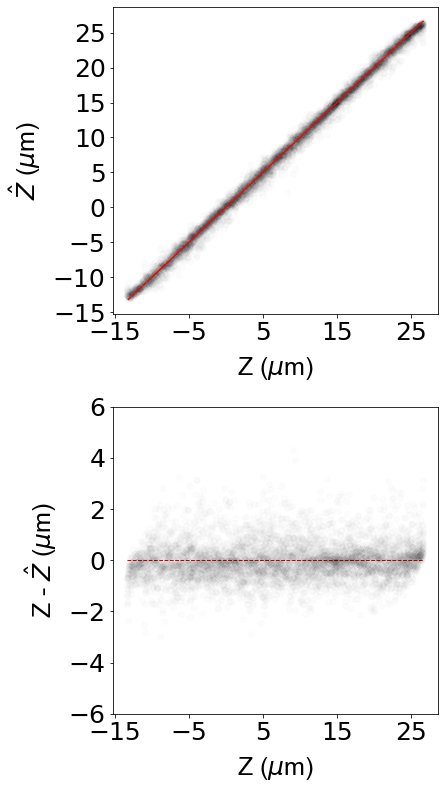

In [15]:
#Plotting performance of the model
fig = plt.figure(figsize=(21, 13))
hfont = {'fontname':'Arial'}
# set the spacing between subplots
fig.subplots_adjust(
                    wspace=0.3, 
                    hspace=0.3)


plt.subplot(2,3,1)
plt.plot(Y_test,predictions,'o',color='k', alpha=0.01)
plt.plot(Y_test,Y_test,'r', linewidth=1, linestyle='--')
plt.yticks(fontsize=25)
plt.xticks([-15,-5,5,15,25],fontsize=25)
plt.xlabel(r"Z ($\mu$m)", fontsize=25, labelpad=10,**hfont)
plt.ylabel(r"$\hat{Z}$ ($\mu$m)", fontsize=25, labelpad=10,**hfont)


plt.subplot(2,3,4)
plt.plot(Y_test,residuals,'o',color='k', alpha=0.01)
plt.hlines(0,min(Y_test),max(Y_test),color='r',linewidth=1,linestyle='--')
plt.yticks(fontsize=25)
plt.xticks([-15,-5,5,15,25],fontsize=25)
plt.xlabel(r"Z ($\mu$m)", fontsize=25, labelpad=10,**hfont)
plt.ylabel(r"Z - $\hat{Z}$ ($\mu$m)", fontsize=25, labelpad=10,**hfont)
plt.ylim([-6,6])
plt.show()
fig.savefig("MBN12_ERT_fits.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#Final step - train model on entire dataset

df_predictors = df[num_attributes].copy()
df_targets = df["Z_labels"].copy()
df_predictors_processed = factored_num_pipeline.fit_transform(df_predictors.copy())

#FINAL MODEL (ALL DATA)
from sklearn.ensemble import ExtraTreesRegressor
extra_trees_reg = ExtraTreesRegressor(n_estimators=1000, max_features=None, max_depth = 40 ,verbose=False, random_state=42, n_jobs=-1)
extra_trees_reg.fit(df_predictors_processed,df_targets)

